# Sklearn models

In this notebook, a usage demo of all the chosen scikit-learn models is presented. In particular, the following have been added to those in the task:
- DecisionTreeClassifier
- QuadraticDiscriminantAnalysis

Furthermore, in this demo the saving of results will be ignored to avoid overwriting the outputs.

## Imports

In [1]:
import os
import warnings
from typing import Dict

import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, GridSearchCV

from src.models.config import best_param_grid_model
from src.models.sklearn_models import balance, preprocess, test_eval, save_fold_model
from src.utils.const import DATA_DIR, SEED, NUM_BINS
from src.utils.util_models import fix_random

In [2]:
warnings.filterwarnings('ignore', category=UserWarning)

### Useful path to data

In [3]:
ROOT_DIR = os.path.join(os.getcwd(), '..')
PROCESSED_DIR = os.path.join(ROOT_DIR, DATA_DIR, 'processed')

### Fix random seed

In [4]:
fix_random(SEED)

## Import final dataset

In [5]:
final_stored = pd.read_parquet(os.path.join(PROCESSED_DIR, 'final.parquet'))
final = (final_stored
         .assign(rating_discrete=pd.cut(final_stored.loc[:, 'rating_mean'], bins=NUM_BINS, labels=False))
         .astype({'rating_discrete': 'int32'})
         .drop(columns=['rating_mean']))

## Train & Test

Trains and tests are performed in the following function. To verify that a certain configuration works well with different test sets and to perform hyperparameter optimization, 5-fold cross validation was implemented internally and externally. The internal one in the sklearn models is handled by the GridSearchCV, which performs the hyperparameter search automatically. Finally, the ` test_eval` function loads the previously saved model and evaluates its performance metrics, also printing the multiclass roc plot when it's possible.


In [6]:
def train_test(df: pd.DataFrame, model_group: str, model_idx: int, param_grid: Dict):
    data = df.loc[:, df.columns != 'rating_discrete']
    target = df['rating_discrete']

    N_SPLITS = 5

    cv_outer = StratifiedKFold(n_splits=N_SPLITS, shuffle=True)

    correct_param_grid = [param_grid[model_group][model_idx]]

    for model_name, estimator, param_grid in correct_param_grid:
        outer_results = []
        outer_f1_results = []
        for fold, (train_idx, test_idx) in enumerate(cv_outer.split(data, y=target), 1):
            print(f'Fold {fold}')
            train_data, test_data = data.iloc[train_idx, :], data.iloc[test_idx, :]
            train_target, test_target = target[train_idx], target[test_idx]

            cv_inner = StratifiedKFold(n_splits=N_SPLITS, shuffle=True)

            train_data_smt, train_target_smt = balance(train_data, train_target)
            train_data_proc, test_data_proc = preprocess(train_data_smt, test_data)

            search = GridSearchCV(estimator=estimator,
                                  param_grid=param_grid,
                                  scoring='accuracy',
                                  cv=cv_inner,
                                  refit=True,
                                  n_jobs=-1,
                                  verbose=3)

            search.fit(train_data_proc, train_target_smt)

            best_model = search.best_estimator_
            save_fold_model(fold, model_name, best_model, notebook=True)

            acc, loss, f1_test = test_eval(fold, model_name, test_data_proc, test_target, True, notebook=True)
            outer_results.append(acc)
            outer_f1_results.append(f1_test)

            print(f'loss={loss:3f}, acc={acc:3f} ,f1-score={f1_test:3f}, cfg={search.best_params_}')

        print(
            f'[{model_name}] [test] Mean accuracy: {np.mean(outer_results):3f} - Mean f1-score: {np.mean(outer_f1_results):3f}')

Since this is a demo, it was decided to use only the best configuration of each model as the hyperparameter space.

## Tree methods

### RandomForestClassifier

Fold 1
Fitting 5 folds for each of 1 candidates, totalling 5 fits


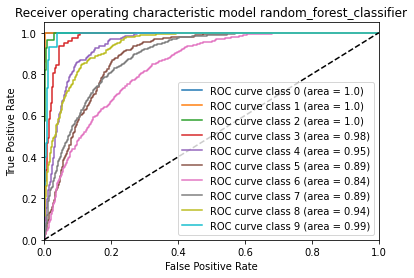

loss=0.392015, acc=0.607985 ,f1-score=0.610316, cfg={'max_depth': 4, 'max_features': 'sqrt', 'n_estimators': 700}
Fold 2
Fitting 5 folds for each of 1 candidates, totalling 5 fits


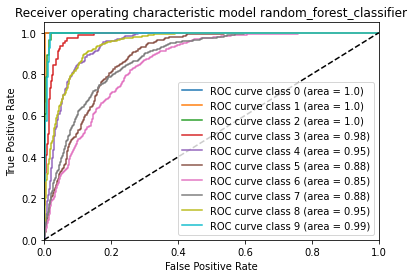

loss=0.382129, acc=0.617871 ,f1-score=0.618424, cfg={'max_depth': 4, 'max_features': 'sqrt', 'n_estimators': 700}
Fold 3
Fitting 5 folds for each of 1 candidates, totalling 5 fits


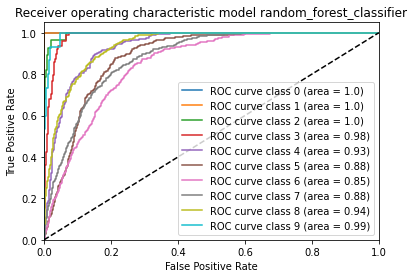

loss=0.396729, acc=0.603271 ,f1-score=0.606887, cfg={'max_depth': 4, 'max_features': 'sqrt', 'n_estimators': 700}
Fold 4
Fitting 5 folds for each of 1 candidates, totalling 5 fits


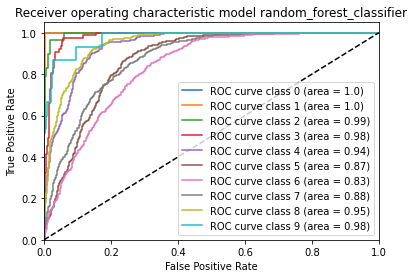

loss=0.386839, acc=0.613161 ,f1-score=0.614675, cfg={'max_depth': 4, 'max_features': 'sqrt', 'n_estimators': 700}
Fold 5
Fitting 5 folds for each of 1 candidates, totalling 5 fits


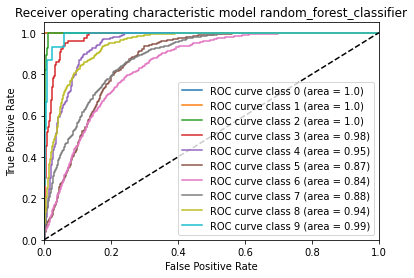

loss=0.403576, acc=0.596424 ,f1-score=0.598484, cfg={'max_depth': 4, 'max_features': 'sqrt', 'n_estimators': 700}
[random_forest_classifier] [test] Mean accuracy: 0.607742 - Mean f1-score: 0.609757


In [7]:
train_test(final, 'tree_based', 0, best_param_grid_model)

### DecisionTreeClassifier

In [8]:
train_test(final, 'tree_based', 1, best_param_grid_model)

Fold 1
Fitting 5 folds for each of 1 candidates, totalling 5 fits
loss=0.358935, acc=0.641065 ,f1-score=0.640973, cfg={'criterion': 'entropy', 'max_depth': 15}
Fold 2
Fitting 5 folds for each of 1 candidates, totalling 5 fits
loss=0.368061, acc=0.631939 ,f1-score=0.631999, cfg={'criterion': 'entropy', 'max_depth': 15}
Fold 3
Fitting 5 folds for each of 1 candidates, totalling 5 fits
loss=0.355268, acc=0.644732 ,f1-score=0.645230, cfg={'criterion': 'entropy', 'max_depth': 15}
Fold 4
Fitting 5 folds for each of 1 candidates, totalling 5 fits
loss=0.358692, acc=0.641308 ,f1-score=0.642256, cfg={'criterion': 'entropy', 'max_depth': 15}
Fold 5
Fitting 5 folds for each of 1 candidates, totalling 5 fits
loss=0.359452, acc=0.640548 ,f1-score=0.640999, cfg={'criterion': 'entropy', 'max_depth': 15}
[decision_tree_classifier] [test] Mean accuracy: 0.639918 - Mean f1-score: 0.640291


## Naive Bayes methods

### GaussianNB

Fold 1
Fitting 5 folds for each of 1 candidates, totalling 5 fits


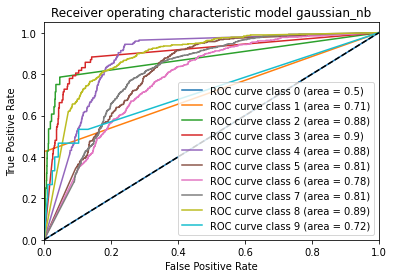

loss=0.530798, acc=0.469202 ,f1-score=0.470833, cfg={'var_smoothing': 8.111308307896872e-07}
Fold 2
Fitting 5 folds for each of 1 candidates, totalling 5 fits


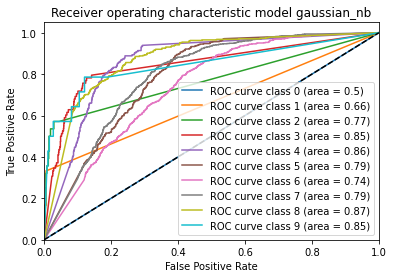

loss=0.561217, acc=0.438783 ,f1-score=0.439128, cfg={'var_smoothing': 8.111308307896872e-07}
Fold 3
Fitting 5 folds for each of 1 candidates, totalling 5 fits


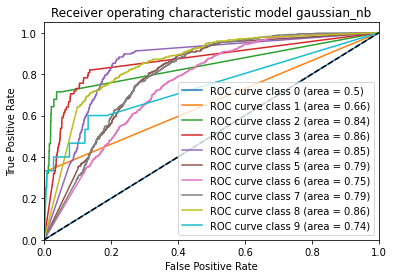

loss=0.558387, acc=0.441613 ,f1-score=0.442779, cfg={'var_smoothing': 8.111308307896872e-07}
Fold 4
Fitting 5 folds for each of 1 candidates, totalling 5 fits


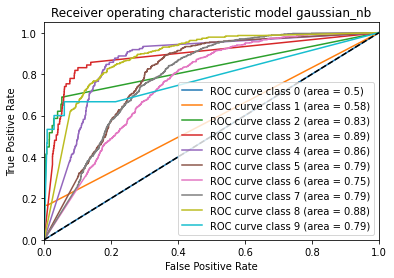

loss=0.558387, acc=0.441613 ,f1-score=0.441054, cfg={'var_smoothing': 8.111308307896872e-07}
Fold 5
Fitting 5 folds for each of 1 candidates, totalling 5 fits


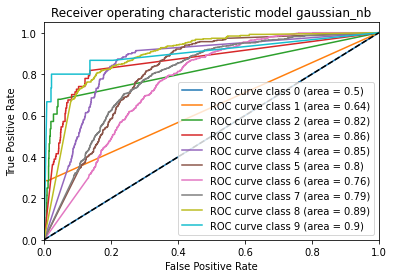

loss=0.547356, acc=0.452644 ,f1-score=0.451189, cfg={'var_smoothing': 8.111308307896872e-07}
[gaussian_nb] [test] Mean accuracy: 0.448771 - Mean f1-score: 0.448996


In [9]:
train_test(final, 'naive_bayes', 0, best_param_grid_model)

### QuadraticDiscriminantAnalysis

Fold 1
Fitting 5 folds for each of 1 candidates, totalling 5 fits


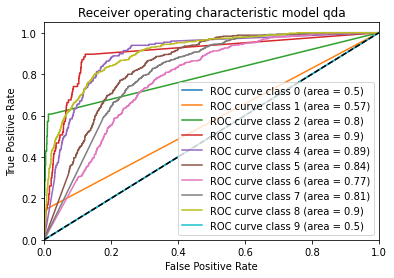

loss=0.474905, acc=0.525095 ,f1-score=0.510755, cfg={'reg_param': 0.001, 'tol': 0.0001}
Fold 2
Fitting 5 folds for each of 1 candidates, totalling 5 fits


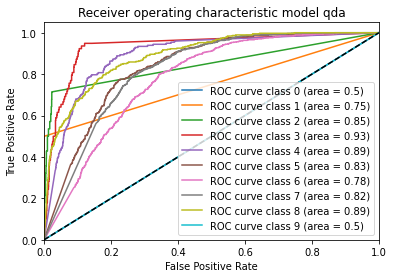

loss=0.468821, acc=0.531179 ,f1-score=0.518330, cfg={'reg_param': 0.001, 'tol': 0.0001}
Fold 3
Fitting 5 folds for each of 1 candidates, totalling 5 fits


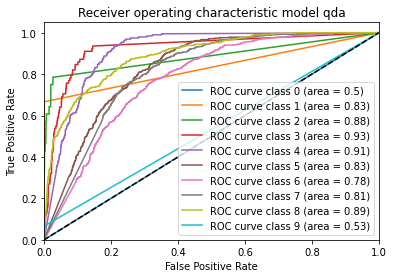

loss=0.467098, acc=0.532902 ,f1-score=0.519027, cfg={'reg_param': 0.001, 'tol': 0.0001}
Fold 4
Fitting 5 folds for each of 1 candidates, totalling 5 fits


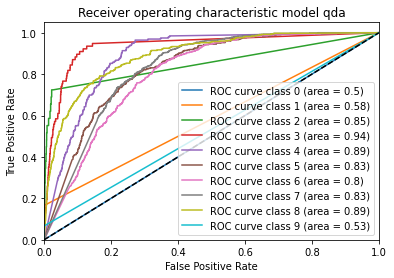

loss=0.461773, acc=0.538227 ,f1-score=0.523490, cfg={'reg_param': 0.001, 'tol': 0.0001}
Fold 5
Fitting 5 folds for each of 1 candidates, totalling 5 fits


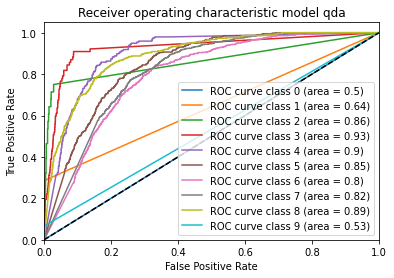

loss=0.453785, acc=0.546215 ,f1-score=0.533612, cfg={'reg_param': 0.001, 'tol': 0.0001}
[qda] [test] Mean accuracy: 0.534724 - Mean f1-score: 0.521043


In [10]:
train_test(final, 'naive_bayes', 1, best_param_grid_model)

## SVM

### SVC

Fold 1
Fitting 5 folds for each of 1 candidates, totalling 5 fits


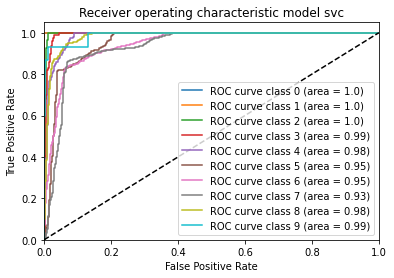

loss=0.175285, acc=0.824715 ,f1-score=0.824196, cfg={'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
Fold 2
Fitting 5 folds for each of 1 candidates, totalling 5 fits


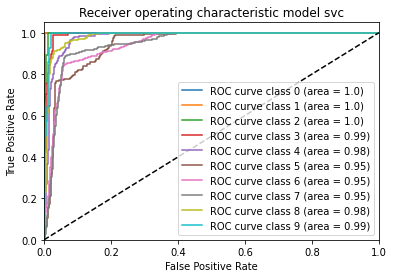

loss=0.165019, acc=0.834981 ,f1-score=0.834671, cfg={'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
Fold 3
Fitting 5 folds for each of 1 candidates, totalling 5 fits


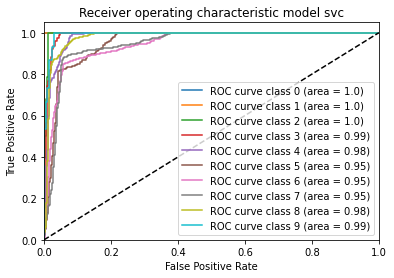

loss=0.166223, acc=0.833777 ,f1-score=0.832970, cfg={'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
Fold 4
Fitting 5 folds for each of 1 candidates, totalling 5 fits


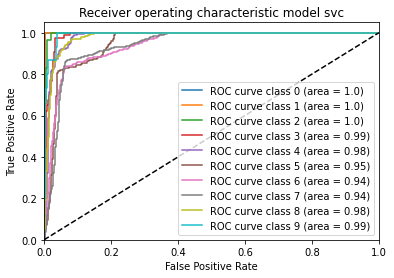

loss=0.177254, acc=0.822746 ,f1-score=0.820599, cfg={'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
Fold 5
Fitting 5 folds for each of 1 candidates, totalling 5 fits


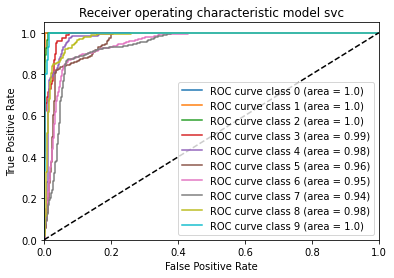

loss=0.168886, acc=0.831114 ,f1-score=0.829979, cfg={'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
[svc] [test] Mean accuracy: 0.829467 - Mean f1-score: 0.828483


In [11]:
train_test(final, 'svm', 0, best_param_grid_model)